# Tarea 1 2025

Las variables tienen la siguiente descripcion:

Date: data medida en frecuencia diaria,
Location: ubicacion del medidor,
Min_Temp: temperatura minima observada,
Max_Temp: temperatura maxima observada,
Leakage: Filtracion medida en el area,
Evaporation: Tasa de evaporacion,
Electricity: Consumo electrico KW,
Parameter: Diferentes sensores de reportando direccion y velocidad de viento en distintos momentos del dia, asi como otras metricas relevantes,
Failure today: El sensor reporta fallo (o no)

**1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base,
realice estadisticas descriptivas sobre las variables importantes 
(Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario.**

R: Inicialmente se cargó el dataframe directamente desde Github y se realizó una revision inicial de las variables a trabajar,
 se hizo la distincion entre los tipos de variables que había, numéricas y categóricas. Luego, se comenzó con la limpiza de los datos,
se identificaron valores atípicos, se detectaron variables con un gran porcentaje de NaN y variables con alta correlación, en base a ello
 se hicieron transformaciones particulares a cada variable necesaria. 
Esta etapa fue muy importante para poder responder las siguientes preguntas.

Obs: El detalle de las acciones hechas está a lo largo del código.

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import sklearn
from sklearn.preprocessing import StandardScaler
import scipy 
from scipy.stats import nbinom
import seaborn as sns
import warnings
from statsmodels.genmod.families import NegativeBinomial
warnings.filterwarnings("ignore")

%matplotlib inline

In [70]:
url="https://raw.githubusercontent.com/juancaros/LAB-MAA/refs/heads/main/data/machine_failure_data.csv"
df=pd.read_csv(url)
df

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,...,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter6_9am,Parameter6_3pm,Parameter7_9am,Parameter7_3pm,Failure_today
0,12/1/2008,3,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,12/2/2008,3,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,12/3/2008,3,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,12/4/2008,3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,12/5/2008,3,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,6/20/2017,42,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No
142189,6/21/2017,42,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No
142190,6/22/2017,42,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No
142191,6/23/2017,42,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No


In [71]:
#Renombramos las variables por simplicidad

df=df.rename(columns={"Parameter1_Speed":"P1_Speed",
                     "Parameter1_Dir":"P1_Dir",
                      "Parameter2_3pm":"P2_3pm",
                     "Parameter2_9am":"P2_9am",
                     "Parameter3_9am":"P3_9am",
                     "Parameter3_3pm":"P3_3pm",
                    "Parameter4_9am":"P4_9am",
                    "Parameter4_3pm":"P4_3pm",
                    "Parameter5_9am":"P5_9am",
                    "Parameter5_3pm":"P5_3pm",
                    "Parameter6_9am":"P6_9am",
                    "Parameter6_3pm":"P6_3pm",
                    "Parameter7_9am":"P7_9am",
                    "Parameter7_3pm":"P7_3pm",
                    })

df['Failure_bin']=df['Failure_today'].apply(lambda x:1 if x=='Yes' else 0)
df.drop('Failure_today', axis=1, inplace=True)


df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 22 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Date         142193 non-null  object 
 1   Location     142193 non-null  int64  
 2   Min_Temp     141556 non-null  float64
 3   Max_Temp     141871 non-null  float64
 4   Leakage      140787 non-null  float64
 5   Evaporation  81350 non-null   float64
 6   Electricity  74377 non-null   float64
 7   P1_Dir       132863 non-null  object 
 8   P1_Speed     132923 non-null  float64
 9   P2_9am       132180 non-null  object 
 10  P2_3pm       138415 non-null  object 
 11  P3_9am       140845 non-null  float64
 12  P3_3pm       139563 non-null  float64
 13  P4_9am       140419 non-null  float64
 14  P4_3pm       138583 non-null  float64
 15  P5_9am       128179 non-null  float64
 16  P5_3pm       128212 non-null  float64
 17  P6_9am       88536 non-null   float64
 18  P6_3pm       85099 non-n

,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,P1_Speed,P3_9am,P3_3pm,P4_9am,P4_3pm,P5_9am,P5_3pm,P6_9am,P6_3pm,P7_9am,P7_3pm,Failure_bin
count,142193.000000,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,24.740655,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,0.221213
std,14.237503,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,0.415065
min,1.000000,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,12.000000,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,25.000000,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,37.000000,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.000000
max,49.000000,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000


In [72]:
#Definimos pares AM/PM de los parámetros.
pares = [
    ('P3_9am', 'P3_3pm'),
    ('P4_9am', 'P4_3pm'),
    ('P5_9am', 'P5_3pm'),
    ('P6_9am', 'P6_3pm'),
    ('P7_9am', 'P7_3pm'),
]

# Se calculó la correlación entre cada par
print("Correlaciones entre pares AM/PM por parámetro:\n")
for col1, col2 in pares:
    if col1 in df.columns and col2 in df.columns:
        corr = df[[col1, col2]].corr().iloc[0, 1]
        print(f"{col1} vs {col2}: {corr:.4f}")
    else:
        print(f"{col1} o {col2} no están en la data")

Correlaciones entre pares AM/PM por parámetro:

P3_9am vs P3_3pm: 0.5200
P4_9am vs P4_3pm: 0.6674
P5_9am vs P5_3pm: 0.9613
P6_9am vs P6_3pm: 0.6041
P7_9am vs P7_3pm: 0.8606


In [73]:
#Vemos que los pares 5 y 7 son los que tienen correlación más alta por lo que creamos columnas con sus promedios.
df['P5'] = (df['P5_9am'] + df['P5_3pm']) / 2
df['P7'] = (df['P7_9am'] + df['P7_3pm']) / 2

# Eliminamos las columnas originales
df.drop(columns=['P5_9am', 'P5_3pm', 'P7_9am', 'P7_3pm'], inplace=True)

In [74]:
# Transformamos de direcciones a grados
dir_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

# Conversión a grados
df['P1_Dir'] = df['P1_Dir'].map(dir_map)
df['P2_9am'] = df['P2_9am'].map(dir_map)
df['P2_3pm'] = df['P2_3pm'].map(dir_map)

# Conversión a componentes circulares
df['P1_Dir_sin'] = np.sin(np.radians(df['P1_Dir']))
df['P1_Dir_cos'] = np.cos(np.radians(df['P1_Dir']))

df['P2_9am_sin'] = np.sin(np.radians(df['P2_9am']))
df['P2_9am_cos'] = np.cos(np.radians(df['P2_9am']))

df['P2_3pm_sin'] = np.sin(np.radians(df['P2_3pm']))
df['P2_3pm_cos'] = np.cos(np.radians(df['P2_3pm']))


In [75]:
# Lista de columnas a eliminar definitivamente.
cols_a_eliminar = [
    'P1_Dir', 'P2_9am', 'P2_3pm',
]

df.drop(columns=[col for col in cols_a_eliminar if col in df.columns], inplace=True)

#Ordenamos las columnas con considerando las variables eliminadas y definidas.
columnas_ordenadas = [
    'Date', 'Location', 'Min_Temp', 'Max_Temp', 'Leakage', 'Evaporation', 'Electricity',
    'P1_Speed',
    'P3_9am', 'P3_3pm', 'P4_9am', 'P4_3pm',
    'P5', 'P6_9am', 'P6_3pm', 'P7',
    'P1_Dir_sin', 'P1_Dir_cos',
    'P2_9am_sin', 'P2_9am_cos',
    'P2_3pm_sin', 'P2_3pm_cos',
    'Failure_bin']
df = df[columnas_ordenadas]

In [77]:
df

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,P1_Speed,P3_9am,P3_3pm,...,P6_9am,P6_3pm,P7,P1_Dir_sin,P1_Dir_cos,P2_9am_sin,P2_9am_cos,P2_3pm_sin,P2_3pm_cos,Failure_bin
0,12/1/2008,3,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,...,8.0,NaN,19.35,-1.000000,-1.836970e-16,-1.000000,-1.836970e-16,-0.923880,3.826834e-01,0
1,12/2/2008,3,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,...,NaN,NaN,20.75,-0.923880,3.826834e-01,-0.382683,9.238795e-01,-0.923880,-3.826834e-01,0
2,12/3/2008,3,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,...,NaN,2.0,22.10,-0.923880,-3.826834e-01,-1.000000,-1.836970e-16,-0.923880,-3.826834e-01,0
3,12/4/2008,3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,...,NaN,NaN,22.30,0.707107,7.071068e-01,0.707107,-7.071068e-01,1.000000,6.123234e-17,0
4,12/5/2008,3,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,...,7.0,8.0,23.75,-1.000000,-1.836970e-16,0.923880,3.826834e-01,-0.707107,7.071068e-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,6/20/2017,42,3.5,21.8,0.0,NaN,NaN,31.0,15.0,13.0,...,NaN,NaN,15.15,1.000000,6.123234e-17,0.923880,-3.826834e-01,1.000000,6.123234e-17,0
142189,6/21/2017,42,2.8,23.4,0.0,NaN,NaN,31.0,13.0,11.0,...,NaN,NaN,16.25,1.000000,6.123234e-17,0.707107,-7.071068e-01,0.923880,3.826834e-01,0
142190,6/22/2017,42,3.6,25.3,0.0,NaN,NaN,22.0,13.0,9.0,...,NaN,NaN,17.70,-0.382683,9.238795e-01,0.707107,-7.071068e-01,0.000000,1.000000e+00,0
142191,6/23/2017,42,5.4,26.9,0.0,NaN,NaN,37.0,9.0,9.0,...,NaN,NaN,19.30,0.000000,1.000000e+00,0.707107,-7.071068e-01,-0.923880,3.826834e-01,0


In [78]:
#Vemos el porcentaje de variables NaN
df.isnull().mean().sort_values(ascending=False) *100


Electricity    47.692924
Evaporation    42.789026
P6_3pm         40.152469
P6_9am         37.735332
P5              9.989240
P2_9am_sin      7.041838
P2_9am_cos      7.041838
P1_Dir_sin      6.561504
P1_Dir_cos      6.561504
P1_Speed        6.519308
P2_3pm_cos      2.656952
P2_3pm_sin      2.656952
P4_3pm          2.538803
P7              2.304614
P3_3pm          1.849599
P4_9am          1.247600
Leakage         0.988797
P3_9am          0.948007
Min_Temp        0.447983
Max_Temp        0.226453
Location        0.000000
Date            0.000000
Failure_bin     0.000000
dtype: float64

In [79]:
#Por la alta cantidad de NaN de P6 decidimos eliminarla del análisis.
#Sin embargo, no lo hacemos con electricity ni con evaporation ya que son datos indispensables para el análisis de las máquinas,
#más adelante trabajaremos con ellas para poder utilizarlas correctamente.
df.drop(columns=['P6_9am', 'P6_3pm'], inplace=True) 


In [80]:
#Vemos el porcentaje de outliers
outlier_counts = {}

for col in df.select_dtypes(include=['int64', 'float64']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_counts[col] = len(outliers)

# Ordenamos de mayor a menor
outlier_counts = dict(sorted(outlier_counts.items(), key=lambda item: item[1], reverse=True))
for k, v in outlier_counts.items():
    print(f"{k}: {(v/len(df))*100} outliers")

Failure_bin: 22.121342119513617 outliers
Leakage: 17.74208294360482 outliers
P1_Speed: 2.114028116714606 outliers
P3_3pm: 1.7286364307666342 outliers
Evaporation: 1.3741886028144845 outliers
P3_9am: 1.222985660334897 outliers
P4_9am: 0.9979394203652782 outliers
P5: 0.7321035494011661 outliers
Max_Temp: 0.3228007004564219 outliers
P7: 0.27638491346268806 outliers
Min_Temp: 0.04360270899411363 outliers
Location: 0.0 outliers
Electricity: 0.0 outliers
P4_3pm: 0.0 outliers
P1_Dir_sin: 0.0 outliers
P1_Dir_cos: 0.0 outliers
P2_9am_sin: 0.0 outliers
P2_9am_cos: 0.0 outliers
P2_3pm_sin: 0.0 outliers
P2_3pm_cos: 0.0 outliers


In [81]:
#Le hacemos una transformación log a leakage por su gran cantindad de outliers, no consideramos failure_bin ya que es binaria.
df['Leakage_log'] = np.log1p(df['Leakage'])  # log(Leakage + 1)
df.drop(columns=['Leakage'], inplace=True)

In [88]:
#Ahora transformamos Evaporation y Electricity
df['Evaporation'] = df['Evaporation'].fillna(df['Evaporation'].median())
df['Electricity'] = df['Electricity'].fillna(df['Electricity'].mean())
df = df.dropna()

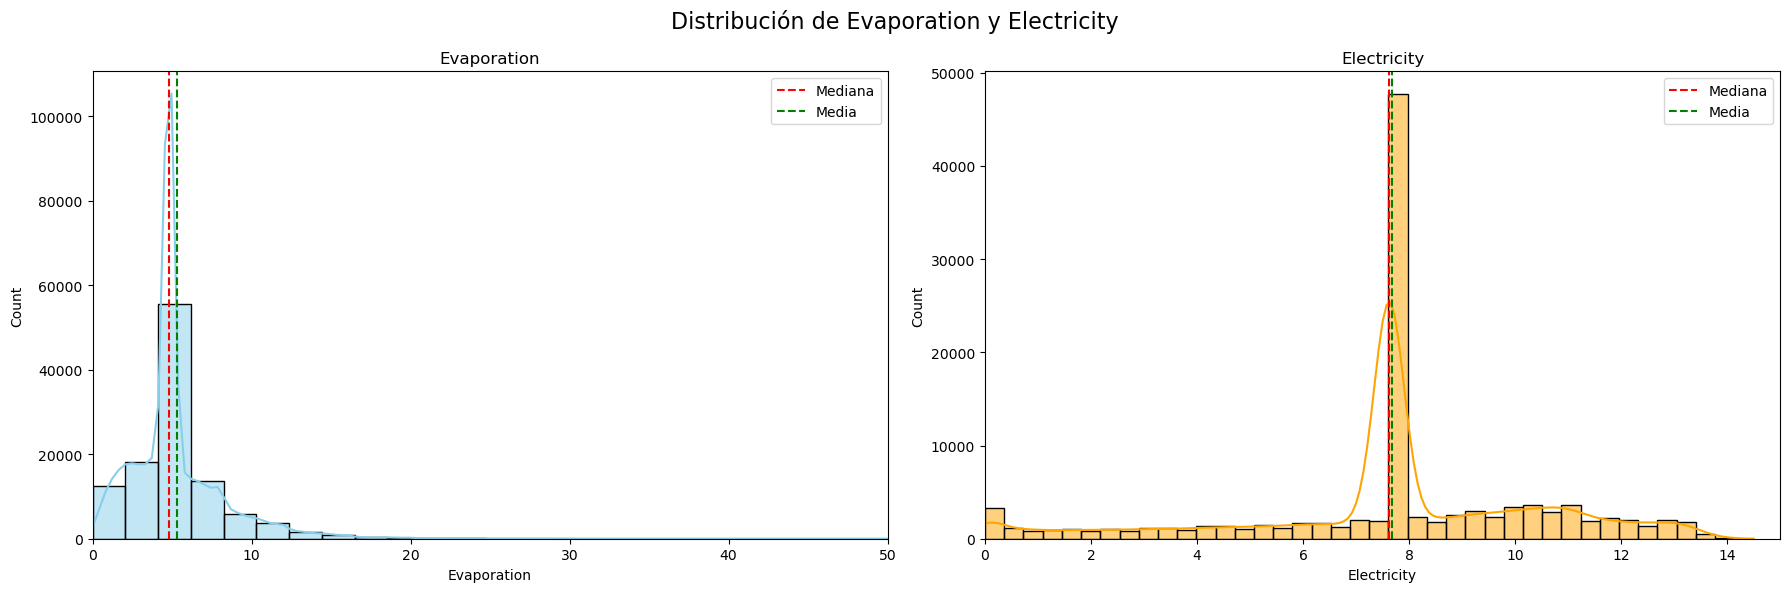

In [95]:
#Electricity y Evaporation tienen muchos NaN y pocos ouliers, es por ello que podemos reeemplazar por mediana o media.
#Electricity es más simetrico por lo que usamos media, Evaporation está sesgada por lo que decidimos usar mediana.
#Demostramos esto con los siguientes gráficos.

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico Evaporation
sns.histplot(df['Evaporation'], bins=40, kde=True, ax=axs[0], color='skyblue')
axs[0].axvline(df['Evaporation'].median(), color='red', linestyle='--', label='Mediana')
axs[0].axvline(df['Evaporation'].mean(), color='green', linestyle='--', label='Media')
axs[0].set_xlim(0, 50)
axs[0].set_title('Evaporation')
axs[0].legend()

# Gráfico Electricity
sns.histplot(df['Electricity'], bins=40, kde=True, ax=axs[1], color='orange')
axs[1].axvline(df['Electricity'].median(), color='red', linestyle='--', label='Mediana')
axs[1].axvline(df['Electricity'].mean(), color='green', linestyle='--', label='Media')
axs[1].set_xlim(0, 15)
axs[1].set_title('Electricity')
axs[1].legend()

plt.suptitle('Distribución de Evaporation y Electricity', fontsize=16)
plt.tight_layout()
plt.show()



In [97]:
df


,Date,Location,Min_Temp,Max_Temp,Evaporation,Electricity,P1_Speed,P3_9am,P3_3pm,P4_9am,...,P5,P7,P1_Dir_sin,P1_Dir_cos,P2_9am_sin,P2_9am_cos,P2_3pm_sin,P2_3pm_cos,Failure_bin,Leakage_log
0,12/1/2008,3,13.4,22.9,4.8,7.624853,44.0,20.0,24.0,71.0,...,1007.40,19.35,-1.000000,-1.836970e-16,-1.000000,-1.836970e-16,-0.923880,3.826834e-01,0,0.470004
1,12/2/2008,3,7.4,25.1,4.8,7.624853,44.0,4.0,22.0,44.0,...,1009.20,20.75,-0.923880,3.826834e-01,-0.382683,9.238795e-01,-0.923880,-3.826834e-01,0,0.000000
2,12/3/2008,3,12.9,25.7,4.8,7.624853,46.0,19.0,26.0,38.0,...,1008.15,22.10,-0.923880,-3.826834e-01,-1.000000,-1.836970e-16,-0.923880,-3.826834e-01,0,0.000000
3,12/4/2008,3,9.2,28.0,4.8,7.624853,24.0,11.0,9.0,45.0,...,1015.20,22.30,0.707107,7.071068e-01,0.707107,-7.071068e-01,1.000000,6.123234e-17,0,0.000000
4,12/5/2008,3,17.5,32.3,4.8,7.624853,41.0,7.0,20.0,82.0,...,1008.40,23.75,-1.000000,-1.836970e-16,0.923880,3.826834e-01,-0.707107,7.071068e-01,0,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,6/20/2017,42,3.5,21.8,4.8,7.624853,31.0,15.0,13.0,59.0,...,1022.95,15.15,1.000000,6.123234e-17,0.923880,-3.826834e-01,1.000000,6.123234e-17,0,0.000000
142189,6/21/2017,42,2.8,23.4,4.8,7.624853,31.0,13.0,11.0,51.0,...,1022.45,16.25,1.000000,6.123234e-17,0.707107,-7.071068e-01,0.923880,3.826834e-01,0,0.000000
142190,6/22/2017,42,3.6,25.3,4.8,7.624853,22.0,13.0,9.0,56.0,...,1021.30,17.70,-0.382683,9.238795e-01,0.707107,-7.071068e-01,0.000000,1.000000e+00,0,0.000000
142191,6/23/2017,42,5.4,26.9,4.8,7.624853,37.0,9.0,9.0,53.0,...,1018.90,19.30,0.000000,1.000000e+00,0.707107,-7.071068e-01,-0.923880,3.826834e-01,0,0.000000


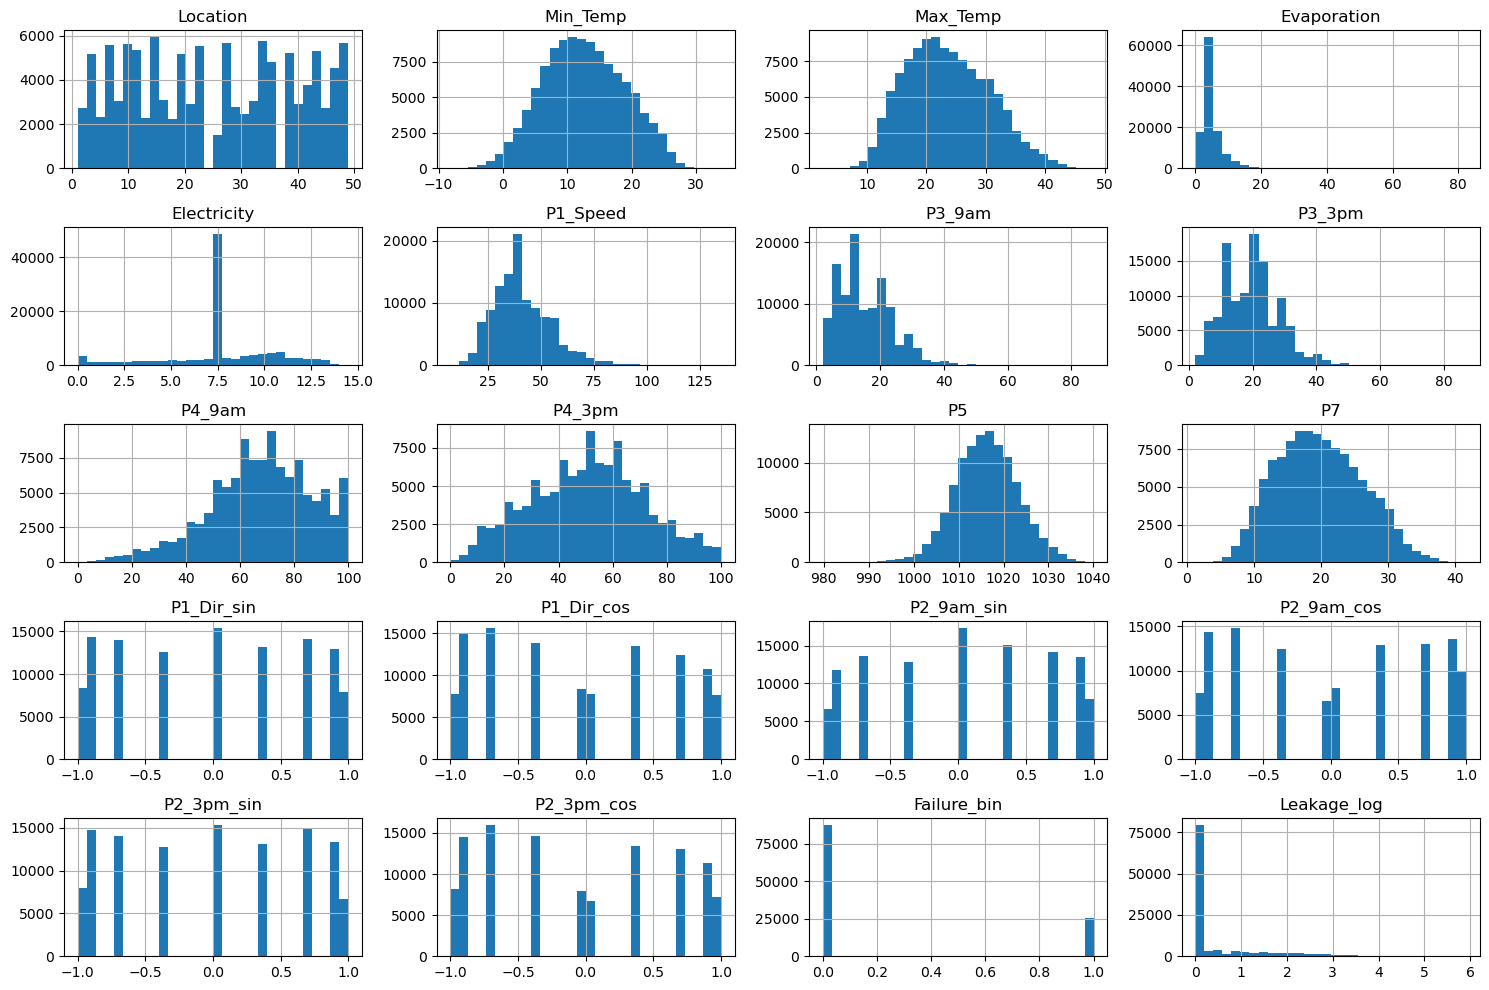

In [99]:
#Creamos gráficos de todas las variables

df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

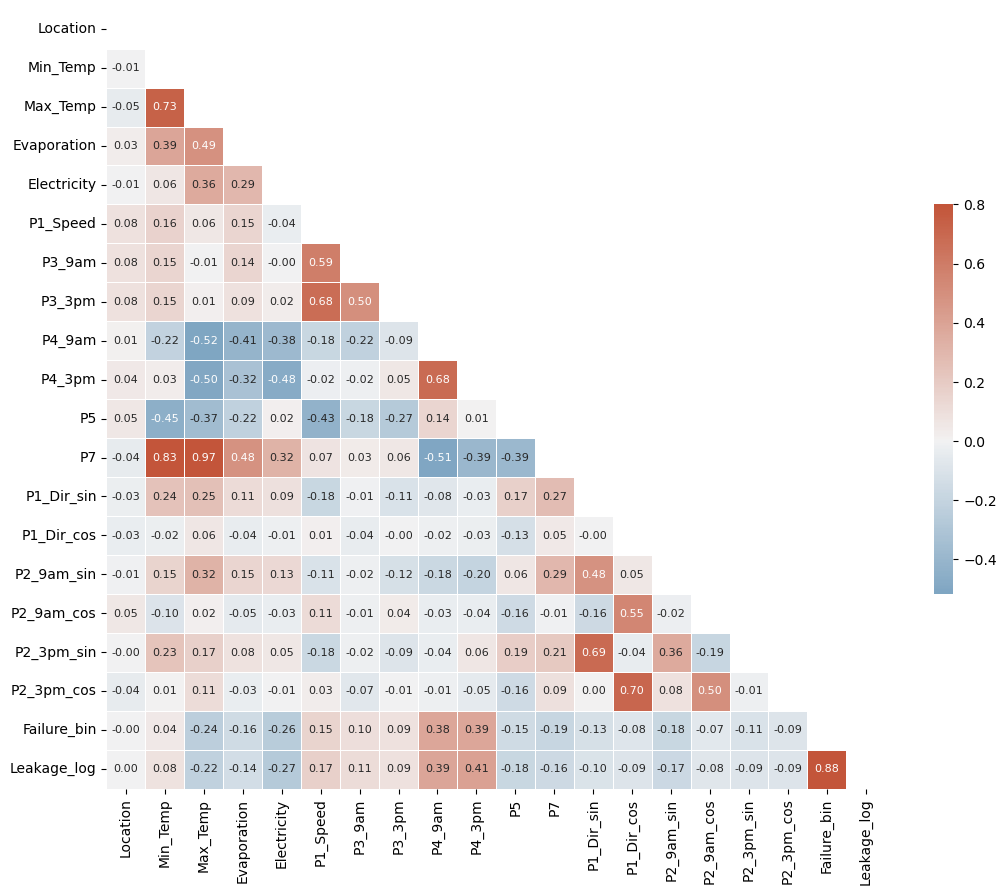

In [100]:
#Creamos un mapa de correlaciones.

# Seleccionamos solo columnas numéricas
corr = df.select_dtypes(include='number').corr()

# Máscara para la mitad superior
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(240, 20, as_cmap=True)

#Graficamos
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.8,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    ax=ax
)

plt.tight_layout()
plt.show()


In [101]:
#Eliminamos Leakage por correlacion muy alta, ademas la variable leakage es muy buen estimador por lo que afecta al resto del modelo.
df.drop(columns=['Leakage_log'], inplace=True)


En este punto tenemos una base de datos limpia y podemos comenzar a responder las preguntas

# OLS


**2. Ejecute un modelo de probabilidad lineal (MCO) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, 
a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.**

R: Se ejecutó un modelo de probabilídad lineas mediante Mínimos Cuadrados Ordinarios (OLS), en el utilizamos como variable dependiente 
Failure_bin, la cual explica si se registro algún fallo en la máquina. Para el conjunto de variables independientes, se eligieron las 
variables numéricas que consideramos como más relevantes que puedan explicar el fallo, ademas se transformo la variable location a 
categorica. Entre las variables utiizadas se encuentran algunas que presetan indicadores muy imprtantes en la operación de la máquina
como las temperaturas mínimas y máximas, la evaporacion y electricidad. El modelo nos permite estimar el efecto de cada variable en
la probabiliadad de que la máquina falle, un aumento en las variables se asocia con una mayor probabilidad de falla. Por ejemplo, un cambio de una unidad en P7, representa un cambio de 15,53 puntos porcentales en la probabilidad de fallo. Finalmente, podemos ver que el modelo explica un 27,4% de los datos.

In [105]:
#Estandarizamos
X = df.drop(['Failure_bin','Date','P1_Dir_sin','P1_Dir_cos','P2_9am_sin','P2_9am_cos','P2_3pm_sin','P2_3pm_cos','Location'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

direction_cols = ['P1_Dir_sin', 'P1_Dir_cos', 'P2_9am_sin', 'P2_9am_cos', 'P2_3pm_sin', 'P2_3pm_cos','Location']
directions = df[direction_cols]

X = pd.concat([X_scaled, directions], axis=1)

# Transformamos location a variable categorica
X['Location'] = X['Location'].astype('category')

X = sm.add_constant(X)

#resultado
print(X.head())
y = df['Failure_bin']




   const  Min_Temp  Max_Temp  Evaporation  Electricity  P1_Speed    P3_9am  \
0    1.0  0.117567 -0.108221    -0.149286    -0.020846  0.241214  0.577742   
1    1.0 -0.841802  0.206845    -0.149286    -0.020846  0.241214 -1.339742   
2    1.0  0.037620  0.292772    -0.149286    -0.020846  0.391345  0.457900   
3    1.0 -0.553991  0.622159    -0.149286    -0.020846 -1.260094 -0.500842   
4    1.0  0.773137  1.237969    -0.149286    -0.020846  0.016018 -0.980214   

     P3_3pm    P4_9am    P4_3pm        P5        P7  P1_Dir_sin    P1_Dir_cos  \
0  0.524408  0.190140 -1.380413 -1.276097 -0.069900   -1.000000 -1.836970e-16   
1  0.291310 -1.237561 -1.235963 -1.016182  0.150181   -0.923880  3.826834e-01   
2  0.757507 -1.554828 -0.995214 -1.167799  0.362402   -0.923880 -3.826834e-01   
3 -1.223831 -1.184683 -1.669313 -0.149798  0.393842    0.707107  7.071068e-01   
4  0.058211  0.771796 -0.850764 -1.131699  0.621783   -1.000000 -1.836970e-16   

   P2_9am_sin    P2_9am_cos  P2_3pm_sin    P

In [108]:
#errores HC0
model = sm.OLS(y, X)
print("\nMODELO OLS:")
results = model.fit(cov_type='HC0')

print(results.summary())




MODELO OLS:
                            OLS Regression Results                            
Dep. Variable:            Failure_bin   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     2433.
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:53:19   Log-Likelihood:                -43465.
No. Observations:              112925   AIC:                         8.697e+04
Df Residuals:                  112906   BIC:                         8.715e+04
Df Model:                          18                                         
Covariance Type:                  HC0                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2355      0.002    

# PROBIT

**3. Ejecute un modelo probit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.**

R:Ahora, ejecutamos un modelo Probit para calcular la probabilidad de falla, es decir Failure_bin =1 y al igual que antes, usamos esta variable, Failure_bin, como dependiente. Además, el análisis de las variables independientes es similar al anterior.
De acuerdo a los resultados, las variables con mayor impacto son P4_9am con un coeficiente marginal de 0,1439, Min_Temp con 0,1114, entre otras. Por otro lado, existen variables con coeficientes marginales negativos, asociados a una disminución en la probabilidad de fallo, como Max_Temp o P5.
Finalmente, se logró un Pseudo R cuadrado de 0.3122, lo que indica una capacidad explicativa buena. 

In [112]:

# Modelo Probit
probit_model = sm.Probit(y, X).fit()
print("\nMODELO PROBIT:")
print(probit_model.summary())

# Efectos marginales del modelo
mfxp = probit_model.get_margeff()
print(mfxp.summary())



Optimization terminated successfully.
         Current function value: 0.366421
         Iterations 7

MODELO PROBIT:
                          Probit Regression Results                           
Dep. Variable:            Failure_bin   No. Observations:               112925
Model:                         Probit   Df Residuals:                   112906
Method:                           MLE   Df Model:                           18
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.3122
Time:                        23:53:20   Log-Likelihood:                -41378.
converged:                       True   LL-Null:                       -60159.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0941      0.011   -101.460      0.000      -1.115      -1.073
Min_Temp  

**#4. Ejecute un modelo logit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.**

R:Al igual que para los modelos anteriores la variable dependiente es Failure_bin. En este caso las variables con un mayor impacto en la probabilídad de falla son P4_9am y Min_Temp, por otro lado Max_Temp y P5 tienen un efecto negativo en la probabilidad de falla. Es decir, las princiaples variable se mantienen respecto a probit, en conclusión, los efectos marginales de probit y logit son consistentes entre si.
Sin embargo, Logit logra interpretar Odd Ratios, lo que significa coeficientes en términos de cambio en el riesgo relativo, lo cual añade una interpretación útil.
Finalmente, Logit mostró un Psudo R cuadrado de 0,3144.



In [114]:

# Modelo Logit
logit_model = sm.Logit(y, X).fit()
print("\nMODELO LOGIT:")
print(logit_model.summary())

# Efectos marginales del modelo
mfxp = logit_model.get_margeff()
print(mfxp.summary())


# Coeficientes
coef = logit_model.params

# Calcular odds ratios
odds_ratios = np.exp(coef)
print(odds_ratios)


Optimization terminated successfully.
         Current function value: 0.365267
         Iterations 7

MODELO LOGIT:
                           Logit Regression Results                           
Dep. Variable:            Failure_bin   No. Observations:               112925
Model:                          Logit   Df Residuals:                   112906
Method:                           MLE   Df Model:                           18
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.3144
Time:                        23:53:21   Log-Likelihood:                -41248.
converged:                       True   LL-Null:                       -60159.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.9476      0.020    -98.068      0.000      -1.986      -1.909
Min_Temp   

In [115]:
import pandas as pd

# Crear la tabla con los coeficientes reales extraídos de los modelos
tabla_coef_final = pd.DataFrame({
    'Variable': [
        'Min_Temp', 'Max_Temp', 'Evaporation', 'Electricity', 'P1_Speed', 
        'P3_9am', 'P3_3pm', 'P4_9am', 'P4_3pm', 'P5', 'P7',
        'P1_Dir_sin', 'P1_Dir_cos', 'P2_9am_sin', 'P2_9am_cos',
        'P2_3pm_sin', 'P2_3pm_cos', 'Location'
    ],
    'OLS': [
        0.0607, -0.2222, -0.0132, -0.0120, 0.0707,
        0.0262, -0.0432, 0.1377, 0.0078, -0.0554, 0.1553,
        -0.0019, -0.0121, -0.0207, -0.0232, -0.0347, -0.0295, -0.0005
    ],
    'Probit': [
        0.5412, -1.0379, -0.1216, 0.0153, 0.2638,
        0.0683, -0.1378, 0.6993, -0.0226, -0.2120, 0.4510,
        -0.0266, -0.0648, -0.1278, -0.1268, -0.0889, -0.0847, -0.0019
    ],
    'Logit': [
        1.0111, -1.8466, -0.2864, 0.0415, 0.4601,
        0.1099, -0.2301, 1.2524, -0.0478, -0.3664, 0.7656,
        -0.0413, -0.1135, -0.2298, -0.2386, -0.1507, -0.1359, -0.0033
    ]
})

# Mostrar tabla
print(tabla_coef_final.to_string(index=False))


   Variable     OLS  Probit   Logit
   Min_Temp  0.0607  0.5412  1.0111
   Max_Temp -0.2222 -1.0379 -1.8466
Evaporation -0.0132 -0.1216 -0.2864
Electricity -0.0120  0.0153  0.0415
   P1_Speed  0.0707  0.2638  0.4601
     P3_9am  0.0262  0.0683  0.1099
     P3_3pm -0.0432 -0.1378 -0.2301
     P4_9am  0.1377  0.6993  1.2524
     P4_3pm  0.0078 -0.0226 -0.0478
         P5 -0.0554 -0.2120 -0.3664
         P7  0.1553  0.4510  0.7656
 P1_Dir_sin -0.0019 -0.0266 -0.0413
 P1_Dir_cos -0.0121 -0.0648 -0.1135
 P2_9am_sin -0.0207 -0.1278 -0.2298
 P2_9am_cos -0.0232 -0.1268 -0.2386
 P2_3pm_sin -0.0347 -0.0889 -0.1507
 P2_3pm_cos -0.0295 -0.0847 -0.1359
   Location -0.0005 -0.0019 -0.0033


# Comparación 

**5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?**

R:Todos los modelos arrojaron resultados consistentes en cuanto a las variables más relevantes a la hora de explicar las fallas. OLS ofrece una primera aproximación decente, pero se cae con las variables binarias. Por otro lado, tanto probit como logit tienen capacidaddes similares, pero logit es el más adecuado debido a su mayor capacidad explicativa con un Pseudo R cuadrado de 0,3144 y a su capacidad de interpretar coeficientes como cambios en riesgo relativo. Finalmente, las variables más robustas que fueron estadisticamente positivas y mantuvieron su signo durante los modelos fueron: Min_ Temp, Max_Temp, P1_Speed, P3_3pm, P4_9am, P5 y P7.

**6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.**

R: Se agregaron los datos a nivel mensual utilizando el promedio de las variables numéricas de cada mes y se contruyo la variable Failres_in_month que enumera el numero de días con fallas por mes. Además, cuando no había ningúna falla su valor era 0. Entre las variables significativas incluidas en el modelo final encontramos Min_Temp (-0.2684),P1_Speed (-0.1038), Max_Temp (-0.1137) y Electricity (-0.0882). También se destacan las variables P3_3pm, P3_9am, P4_3pm, P4_9am y P7 con coeficientes positivos y significativos.
En conclusión, el modelo mostró buena capacidad explicativa en relación al conteo mensual de fallas, y la mayoría de las variables seleccionadas son coherentes con los resultados de modelos anteriores.

In [119]:
df['Date'] = pd.to_datetime(df['Date'])

# Creamos columna 'YearMonth' 
df['YearMonth'] = df['Date'].dt.to_period('M')

# Variables a excluir del promedio mensual
excluir = [
    'Date', 'Location',  
    'P1_Dir_sin', 'P1_Dir_cos',
    'P2_9am_sin', 'P2_9am_cos',
    'P2_3pm_sin', 'P2_3pm_cos',
    'Failure_bin'
]

# Filtrar solo las variables numéricas excluyendo las no deseadas
variables_numericas = df.select_dtypes(include='number').columns.difference(excluir)

# Promedio mensual de las variables numéricas seleccionadas
promedios_mensuales = df.groupby('YearMonth')[variables_numericas].mean()

# Contar cantidad de fallos por mes
fallas_mensuales = df.groupby('YearMonth')['Failure_bin'].sum()

# Unir ambos en un solo DataFrame
data_mensual = promedios_mensuales.copy()
data_mensual['Failures_in_month'] = fallas_mensuales
data_mensual['Failures_in_month'] = data_mensual['Failures_in_month'].fillna(0).astype(int)

# Variables para el modelo
X = data_mensual.drop(columns=['Failures_in_month'])
y = data_mensual['Failures_in_month']

# Agregamos constante
X = sm.add_constant(X)

# Modelo Poisson
modelo_poisson = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print("\nMODELO POISSON:")
print(modelo_poisson.summary())




MODELO POISSON:
                 Generalized Linear Model Regression Results                  
Dep. Variable:      Failures_in_month   No. Observations:                  113
Model:                            GLM   Df Residuals:                      101
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1029.4
Date:                Thu, 24 Apr 2025   Deviance:                       1269.9
Time:                        23:53:23   Pearson chi2:                 1.13e+03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.2888      4.649

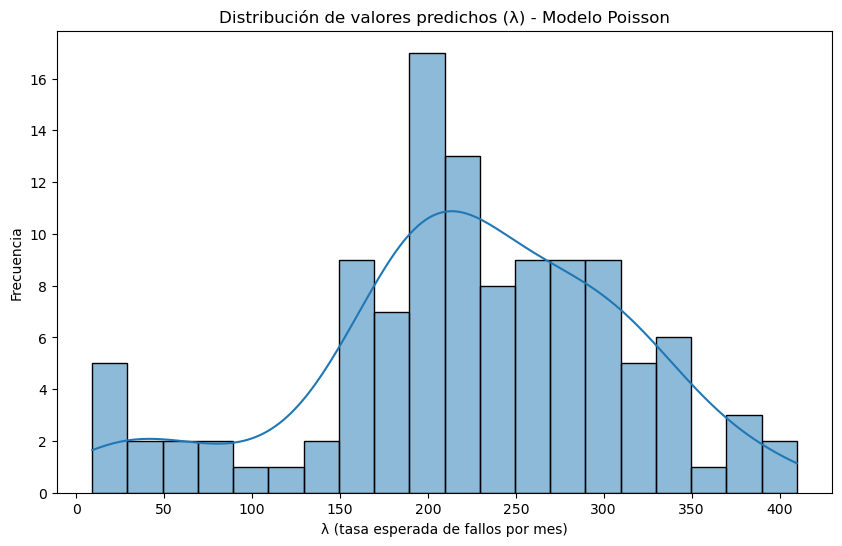

In [120]:
data_mensual['plambda'] = modelo_poisson.mu

# Graficar el histograma de las lambdas predichas
plt.figure(figsize=(10, 6))
sns.histplot(data=data_mensual, x="plambda", bins=20, kde=True)
plt.title('Distribución de valores predichos (λ) - Modelo Poisson')
plt.xlabel('λ (tasa esperada de fallos por mes)')
plt.ylabel('Frecuencia')
plt.show()


In [125]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

       variable            VIF
0         const  480210.842477
1   Electricity      19.267710
2   Evaporation      46.879425
3      Max_Temp    1051.150024
4      Min_Temp     127.920735
5      P1_Speed      12.417066
6        P3_3pm      12.968274
7        P3_9am      11.246534
8        P4_3pm      32.472706
9        P4_9am      33.269094
10           P5       4.757032
11           P7    1250.761421


Un VIF mayor a 10 puede indicar que el modelo no está bien, en este caso la mayoria de las variables está muy por encima de ese valor. 
Dado que Poisson no es le modelo ideal a usar, probamos con Binomial Negativa

# Dispersion y alpha
**7. Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.**

R: Se determino una sobre dispersión alta de 12,57, además se calculo el valor optimo de alpha obteniendo 1.0303.

In [129]:
#La dispersion se calcula como Deviance/df residual, en este caso nos da 1269,9/101 =12,57.

# Obtener predicciones del modelo Poisson
predictions = modelo_poisson.predict(X)  

# Calcular la variable auxiliar
aux = ((data_mensual['Failures_in_month'] - predictions) ** 2 - predictions) / predictions

# Regresión auxiliar para estimar ln(alpha)
aux_model = sm.OLS(aux, predictions).fit()
print(aux_model.summary())

# Obtener coeficiente y calcular alpha
coef_aux = aux_model.params[0]
print(f"\nCoeficiente de la regresión auxiliar: {coef_aux:.4f}")

# Estimación de alpha
alpha_estimado = np.exp(coef_aux)
print(f"Alpha estimado (exp(coef)): {alpha_estimado:.4f}")


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.198
Model:                            OLS   Adj. R-squared (uncentered):              0.191
Method:                 Least Squares   F-statistic:                              27.60
Date:                Thu, 24 Apr 2025   Prob (F-statistic):                    7.18e-07
Time:                        23:53:24   Log-Likelihood:                         -462.31
No. Observations:                 113   AIC:                                      926.6
Df Residuals:                     112   BIC:                                      929.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.**

R: Este modelo fue adecuado debido a la sobredispersión detectada previamente y un alpha de 1.03. Entre las variables incluidas, solo P3_9am fue estadísticamente significativa con un p igual a 0.001, mostrando que su aumento se asocia con más fallas. Las demás variables no fueron significativas, posiblemente por el menor tamaño muestral y la agregación mensual que se realizó. Esto indica que P3_9am es muy buen predictor

In [132]:
alpha_initial = 1.03

negbin_model = sm.GLM(
    y, 
    X, 
    family=sm.families.NegativeBinomial(alpha=alpha_initial)
).fit()

print(negbin_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      Failures_in_month   No. Observations:                  113
Model:                            GLM   Df Residuals:                      101
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -703.26
Date:                Thu, 24 Apr 2025   Deviance:                       12.610
Time:                        23:53:25   Pearson chi2:                     9.81
No. Iterations:                    17   Pseudo R-squ. (CS):             0.3322
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -15.0099     66.887     -0.224      

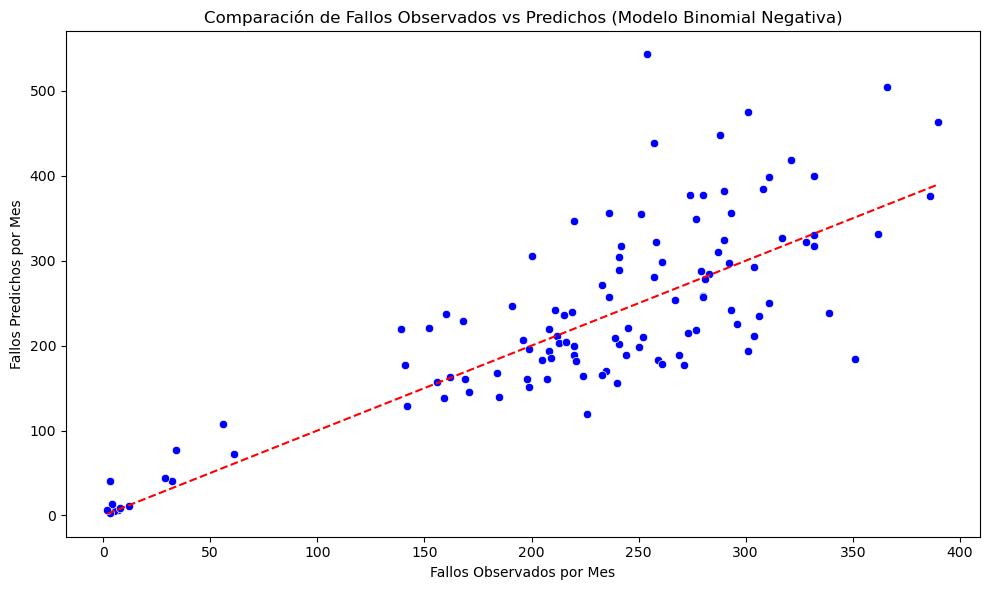

In [134]:

modelo_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=1.03)).fit()

# Agregamos las predicciones
data_mensual['ypred'] = modelo_nb.predict(X) 


plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_mensual, x='Failures_in_month', y='ypred', color='blue')
plt.plot(
    [data_mensual['Failures_in_month'].min(), data_mensual['Failures_in_month'].max()],
    [data_mensual['Failures_in_month'].min(), data_mensual['Failures_in_month'].max()],
    'r--'
)
plt.xlabel('Fallos Observados por Mes')
plt.ylabel('Fallos Predichos por Mes')
plt.title('Comparación de Fallos Observados vs Predichos (Modelo Binomial Negativa)')
plt.tight_layout()
plt.show()



**9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?**

R: Ambos modelos muestran resultados similares en cuanto al a los efectos de las variables. Sin embargo, el modelo Binomial Negativa es más apropiado por la sobredispersión encontrada. Aunque identifica menos variables significativas que Poisson, esto se puede deber al menor número de observaciones mensuales que hay. La variable P3_9am fue la más robusta, manteniendo su efecto positivo y significancia en ambos modelos, es la que mas se reomienda usar para determinar las fallas.